# ST>A | Special Topics in Astrodynamics | ae4889

In [1]:
import datetime
%load_ext tensorboard
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras_visualizer import visualizer
from IPython.core.display import Image, display

print(f"tensorflow version: {tf.__version__}")
plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(precision=4, suppress=True)


raw_data = np.loadtxt('Output.txt',skiprows=1,delimiter=',')

tensorflow version: 2.0.0


In [2]:
column_names = ['Start time [s]', 'Arrival time [s]', '∆V_1 [m/s]', '∆V_2 [m/s]']
raw_dataset = pd.DataFrame(data=raw_data, columns=column_names)

In [3]:
dataset = raw_dataset.copy()

### Raw Data

In [4]:
dataset

,Start time [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
0,717163200.0,754660800.0,3701.491287,4798.800044
1,717422400.0,749217600.0,3868.755226,5160.710719
2,717163200.0,725976000.0,150.008672,402.131481
3,715780800.0,739713600.0,3933.863749,5402.477924
4,718113600.0,748353600.0,3916.270796,5254.939926
...,...,...,...,...
99995,717163200.0,725803200.0,57.775348,683.116886
99996,718977600.0,731332800.0,3502.628723,4498.641950
99997,716990400.0,752068800.0,3767.849092,4967.023930
99998,717940800.0,752328000.0,3789.613801,4975.094567


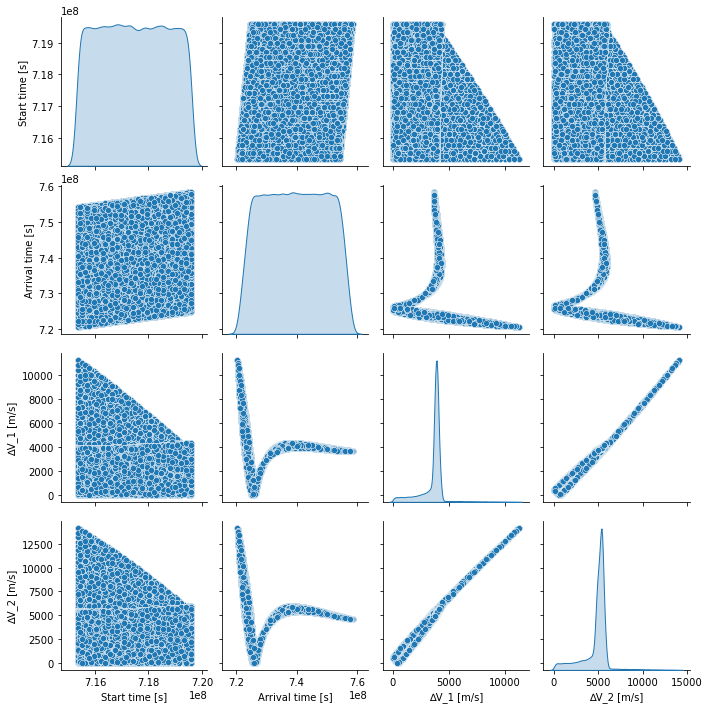

In [5]:
sns.pairplot(dataset, diag_kind="kde")

### Split Data Up

In [6]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Training Data

In [7]:
train_dataset

,Start time [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
3582,718718400.0,724852800.0,2601.716879,4060.680540
60498,717508800.0,737208000.0,4001.013320,5432.500511
53227,715435200.0,745848000.0,3891.064349,5288.119148
21333,718977600.0,756734400.0,3683.638405,4687.861579
3885,718632000.0,755006400.0,3720.015338,4806.306987
...,...,...,...,...
27389,718632000.0,725198400.0,1784.465663,3004.672396
8871,716472000.0,732542400.0,3495.209976,4589.100579
47812,719496000.0,758203200.0,3674.561535,4590.883176
4539,716644800.0,736948800.0,3909.356236,5322.021656


In [8]:
train_dataset.describe()

,Start time [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
count,8.000000e+04,8.000000e+04,80000.000000,80000.000000
mean,7.174556e+08,7.394829e+08,3551.582772,4737.753298
std,1.246090e+06,9.810521e+06,1108.856078,1524.673941
min,7.153488e+08,7.205328e+08,0.275321,2.204792
25%,7.163856e+08,7.310736e+08,3560.871874,4655.382076
50%,7.174224e+08,7.394544e+08,3840.149250,5134.456582
75%,7.185456e+08,7.479216e+08,3978.692978,5417.120730
max,7.195824e+08,7.583760e+08,11256.830967,14123.314076


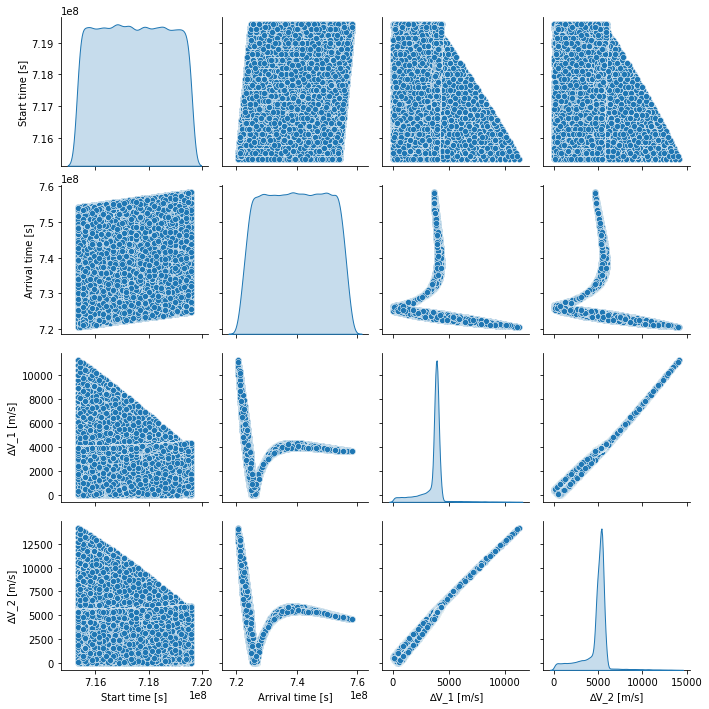

In [9]:
sns.pairplot(train_dataset, diag_kind="kde")

### Normalisation

In [10]:
train_data_normalised = train_dataset.copy()

def norm_time(df):
    return (df - df.min()) / (df.max() - df.min())

def norm(df):
    df_stats = df.describe()
    return (df - df_stats.loc['mean']) / df_stats.loc['std']

for column in column_names[-2:]:
    train_data_normalised[column] = norm(dataset[column])

for column in column_names[:2]:
    train_data_normalised[column] = norm_time(dataset[column])

In [11]:
train_data_normalised

,Start time [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
3582,0.795918,0.114155,-0.853488,-0.441478
60498,0.510204,0.440639,0.407644,0.457783
53227,0.020408,0.668950,0.308552,0.363138
21333,0.857143,0.956621,0.121607,-0.030346
3885,0.775510,0.910959,0.154392,0.047298
...,...,...,...,...
27389,0.775510,0.123288,-1.590045,-1.133717
8871,0.265306,0.317352,-0.048217,-0.095086
47812,0.979592,0.995434,0.113426,-0.093918
4539,0.306122,0.433790,0.325037,0.385361


In [12]:
train_data_normalised.describe()

,Start time [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
count,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.497639,0.500753,0.002590,0.002359
std,0.294333,0.259241,0.999369,0.999461
min,0.000000,0.000000,-3.198067,-3.101908
25%,0.244898,0.278539,0.010962,-0.051637
50%,0.489796,0.500000,0.262664,0.262408
75%,0.755102,0.723744,0.387528,0.447701
max,1.000000,1.000000,6.947033,6.154823


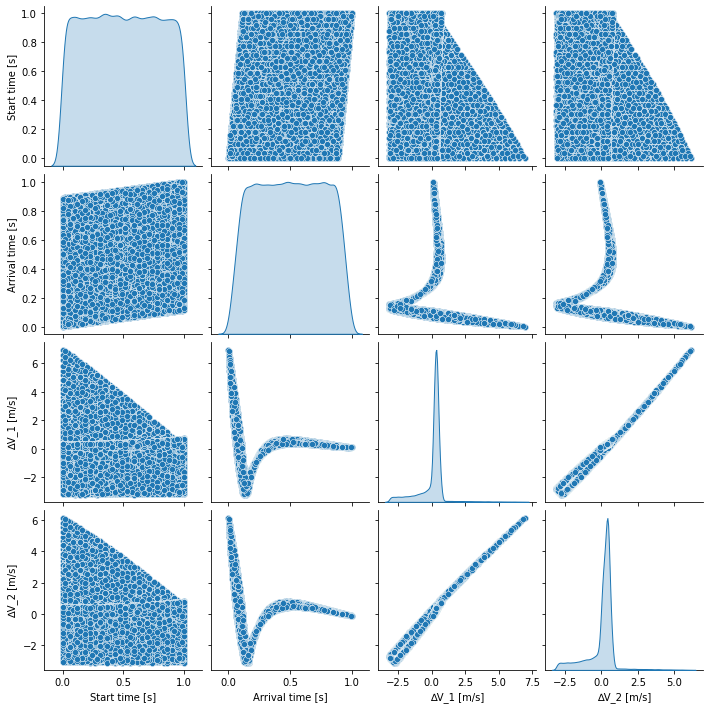

In [13]:
sns.pairplot(train_data_normalised, diag_kind="kde")

Training data

In [14]:
train_data_normalised

,Start time [s],Arrival time [s],∆V_1 [m/s],∆V_2 [m/s]
3582,0.795918,0.114155,-0.853488,-0.441478
60498,0.510204,0.440639,0.407644,0.457783
53227,0.020408,0.668950,0.308552,0.363138
21333,0.857143,0.956621,0.121607,-0.030346
3885,0.775510,0.910959,0.154392,0.047298
...,...,...,...,...
27389,0.775510,0.123288,-1.590045,-1.133717
8871,0.265306,0.317352,-0.048217,-0.095086
47812,0.979592,0.995434,0.113426,-0.093918
4539,0.306122,0.433790,0.325037,0.385361


In [15]:
train_data_normalised.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Start time [s],80000.0,0.497639,0.294333,0.000000,0.244898,0.489796,0.755102,1.000000
Arrival time [s],80000.0,0.500753,0.259241,0.000000,0.278539,0.500000,0.723744,1.000000
∆V_1 [m/s],80000.0,0.002590,0.999369,-3.198067,0.010962,0.262664,0.387528,6.947033
∆V_2 [m/s],80000.0,0.002359,0.999461,-3.101908,-0.051637,0.262408,0.447701,6.154823


## Model


In [16]:
model = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=[2]),
    layers.Dense(50, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(50, activation='relu'),
    layers.Dense(2)
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 5,782
Trainable params: 5,782
Non-trainable params: 0
_________________________________________________________________


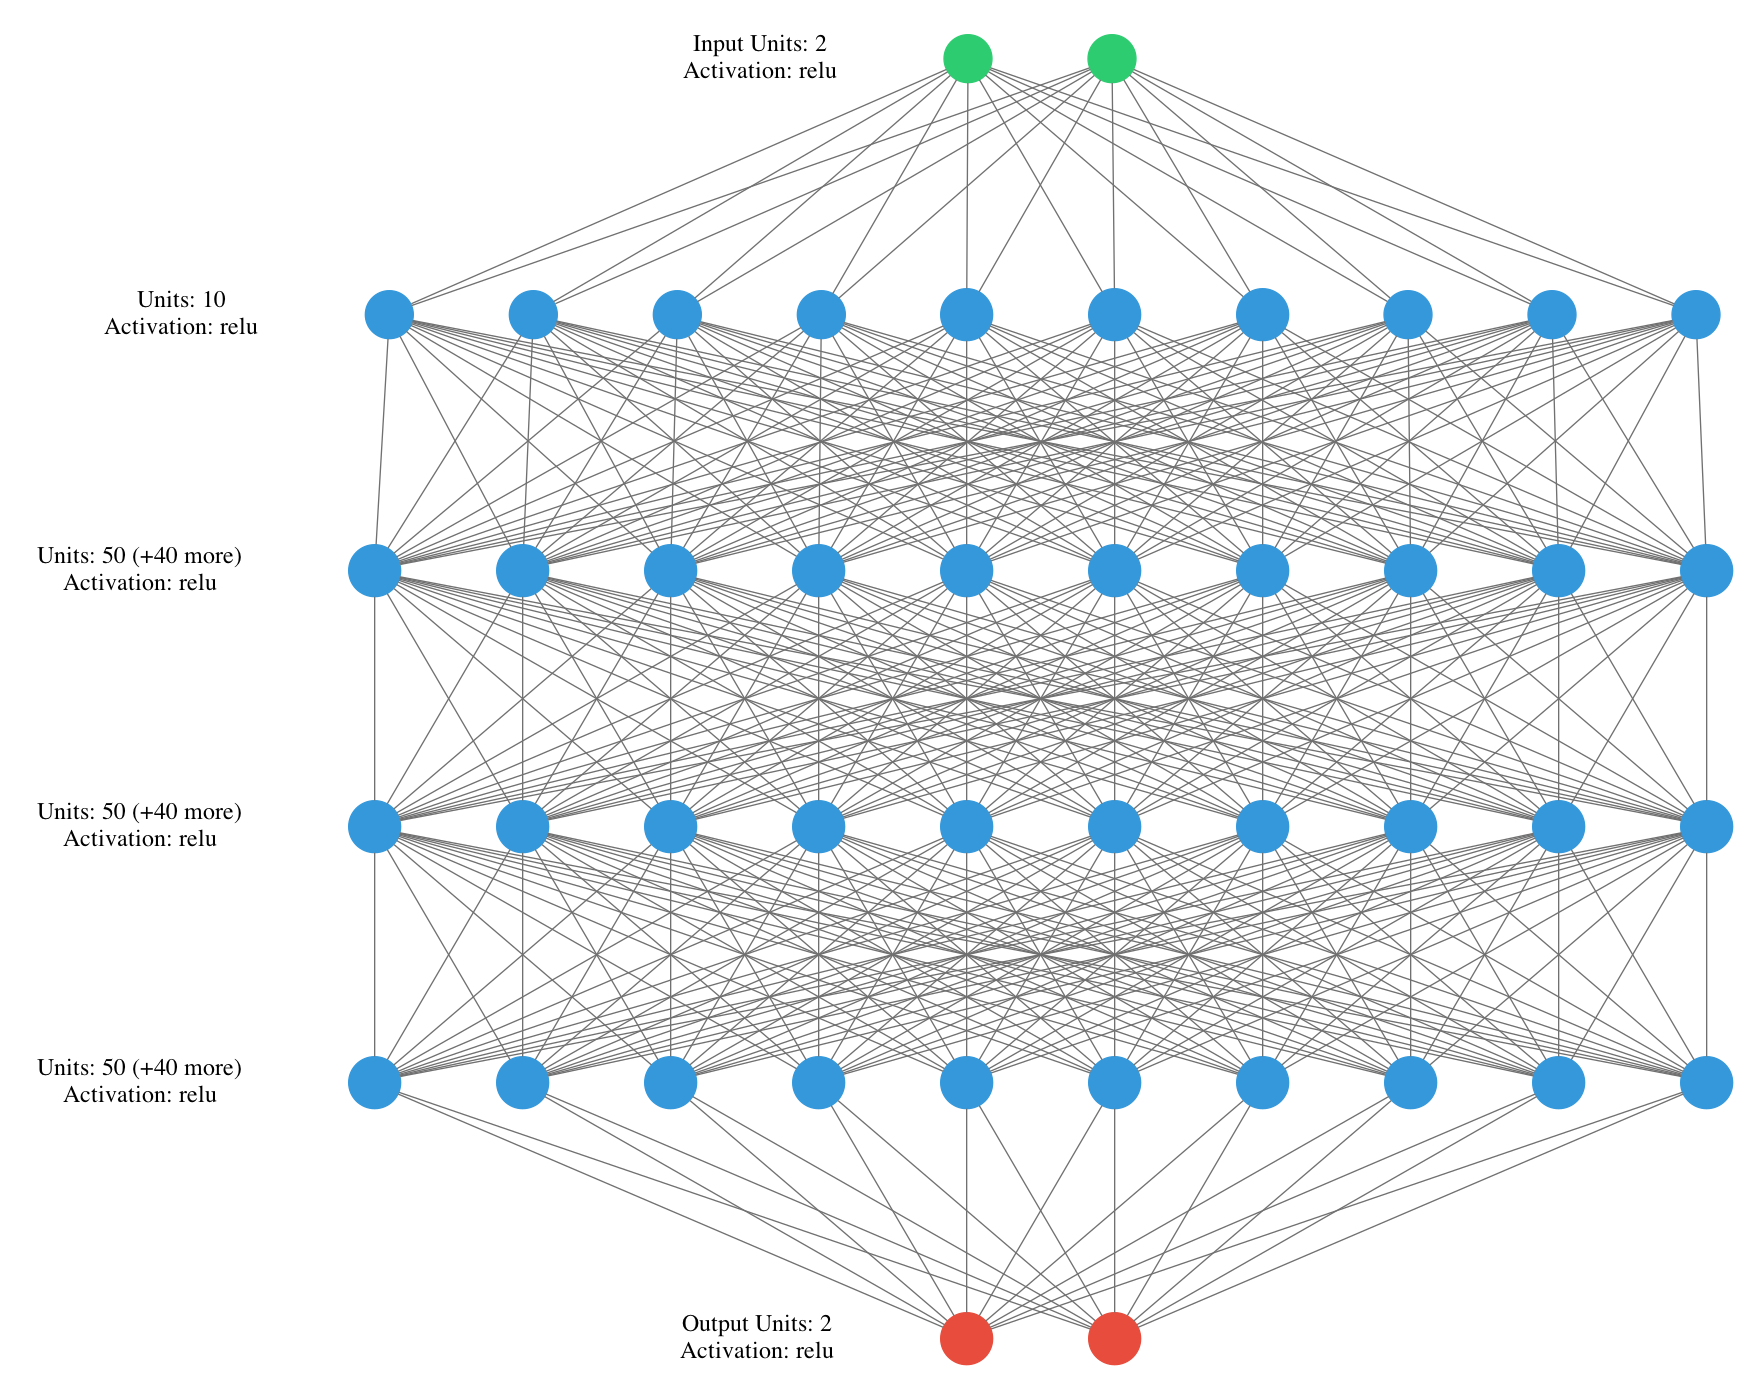

In [28]:
visualizer(model, format='png')
display((Image(filename='graph.png')))

In [19]:
%%time
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

history = model.fit(train_data_normalised[column_names[:2]].to_numpy(),
                    train_data_normalised[column_names[2:]].to_numpy(),
                    validation_split=0.2,
                    epochs=1000,
                    batch_size=100,
                    callbacks=[tensorboard_callback, early_stop])

Train on 64000 samples, validate on 16000 samples
Epoch 1/1000
64000/64000 [==============================] - 3s 44us/sample - loss: 0.2879 - accuracy: 0.8005 - val_loss: 0.0052 - val_accuracy: 0.9545
Epoch 2/1000
64000/64000 [==============================] - 2s 29us/sample - loss: 0.0032 - accuracy: 0.9587 - val_loss: 0.0018 - val_accuracy: 0.9720
Epoch 3/1000
64000/64000 [==============================] - 2s 31us/sample - loss: 0.0016 - accuracy: 0.9674 - val_loss: 0.0010 - val_accuracy: 0.9730
Epoch 4/1000
64000/64000 [==============================] - 2s 29us/sample - loss: 9.8270e-04 - accuracy: 0.9712 - val_loss: 9.6022e-04 - val_accuracy: 0.9756
Epoch 5/1000
64000/64000 [==============================] - 2s 28us/sample - loss: 7.0870e-04 - accuracy: 0.9726 - val_loss: 4.2511e-04 - val_accuracy: 0.9719
Epoch 6/1000
64000/64000 [==============================] - 2s 27us/sample - loss: 5.7693e-04 - accuracy: 0.9749 - val_loss: 0.0013 - val_accuracy: 0.9754
Epoch 7/1000
64000/64000

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
120,0.000175,0.989953,0.000269,0.974000,120
121,0.000180,0.989484,0.000046,0.992125,121
122,0.000151,0.989078,0.000034,0.989000,122
123,0.000125,0.989625,0.000102,0.991375,123
124,0.000295,0.988391,0.000082,0.991125,124


In [24]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

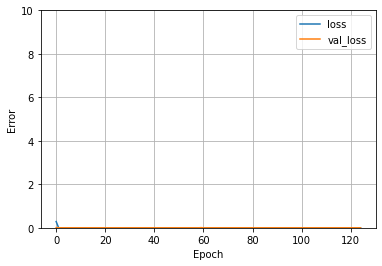

In [23]:
plot_loss(history)